# Rental Property Comparisons
Like many out there I want to retire early.  This means that I need to consider how to invest outside of the IRA and 401K options.  I believe that rental properties help to provide this by providing income outside of the tradition methods, but to accomplish this you need to find the right properties for the investment.  Part one of this project will walk through building a function which will assess these properties.  
For this assessment we will begin by importing the necessary modules.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from datetime import date
from matplotlib import rcParams

Now that we have the necessary modules we can start to build the necessary calculations for assessing the properties.

In [2]:
def Payment(interest_rate, years, ppyear, principal, add_princ, start_date):
    pmt = np.pmt(interest_rate/ppyear, years*ppyear, principal)
    return pmt
def Interest(interest_rate, years, ppyear, principal, add_princ, start_date, per):
    ipmt = np.ipmt(interest_rate/ppyear, per, years*ppyear, principal)
    return ipmt
def Principal(interest_rate, years, ppyear, principal, add_princ, start_date, per):
    ppmt = np.ppmt(interest_rate/ppyear, per, years*ppyear, principal)
    return ppmt

Now that there is a function to create our data table we need to gather the variables.

In [3]:
interest_rate = .04
years = 30
ppyear = 12
principal = 200000
add_princ = 50
start_date = date(2016, 1,1)
per = 1

Next, we can start to build an amortization table.  We will start by creating the initial date range for the table.

In [4]:
rng = pd.date_range(start_date, periods= (years * ppyear), freq='MS')
rng.name = 'Payment_Date'

Now we can design the rest of the table.

In [5]:
table1 = pd.DataFrame(index=rng,columns=['Payment',
                                         'Principal',
                                         'Interest',
                                         'Additional Principal',
                                         'Cumulative Principal',
                                         'Balance'],
                      dtype='float')
table1.reset_index(inplace=True)
table1.index +=1
table1.index.name ='Period'

Next, we will fill the Payment, Principal, and Interest columns.

In [6]:
table1['Payment'] = Payment(interest_rate,years, ppyear, principal, add_princ, start_date)
table1['Principal'] = Principal(interest_rate, years, ppyear, principal, add_princ, start_date, table1.index)
table1['Interest'] = Interest(interest_rate, years, ppyear, principal, add_princ, start_date, table1.index)

C:\Users\buzzt\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: numpy.pmt is deprecated and will be removed from NumPy 1.20. Use numpy_financial.pmt instead (https://pypi.org/project/numpy-financial/).
  
C:\Users\buzzt\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: numpy.ppmt is deprecated and will be removed from NumPy 1.20. Use numpy_financial.ppmt instead (https://pypi.org/project/numpy-financial/).
  
C:\Users\buzzt\anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: numpy.ipmt is deprecated and will be removed from NumPy 1.20. Use numpy_financial.ipmt instead (https://pypi.org/project/numpy-financial/).
  """


With the three main columns we can now add in the additional principal payments to the table.

In [7]:
table1['Additional Principal'] = add_princ

Finally, we need to update the balance column.

In [8]:
table1['Cumulative Principal'] = (table1['Principal'] - table1['Additional Principal']).cumsum()
table1['Cumulative Principal'] = table1['Cumulative Principal'].clip(lower=-principal)
table1['Balance'] = principal + table1['Cumulative Principal']
table1 = table1.round(2)

With all of the columns filled we now need to clean the table to remove the rows for early pay offs.

In [9]:
last_payment = table1.query('Balance <= 0')['Balance'].idxmax(axis=1, skipna=True)
table1.loc[last_payment, 'Principal'] = -(table1.loc[last_payment-1, 'Balance'])
table1.loc[last_payment, 'Payment'] = table1.loc[last_payment, ['Principal','Interest']].sum()
table1.loc[last_payment, 'Additional Principal'] = 0
table1 = table1.loc[0:last_payment]
table1

,Payment_Date,Payment,Principal,Interest,Additional Principal,Cumulative Principal,Balance
Period,,,,,,,
1,2016-01-01,-954.83,-288.16,-666.67,50,-338.16,199661.84
2,2016-02-01,-954.83,-289.12,-665.71,50,-677.29,199322.71
3,2016-03-01,-954.83,-290.09,-664.74,50,-1017.38,198982.62
4,2016-04-01,-954.83,-291.06,-663.78,50,-1358.43,198641.57
5,2016-05-01,-954.83,-292.03,-662.81,50,-1700.46,198299.54
...,...,...,...,...,...,...,...
338,2044-02-01,-954.83,-884.48,-70.36,50,-196677.93,3322.07
339,2044-03-01,-954.83,-887.42,-67.41,50,-197615.36,2384.64
340,2044-04-01,-954.83,-890.38,-64.45,50,-198555.74,1444.26


Anyone that has a mortgage will quickly notice that we are still missing escrow for taxes and insurance.  We can estimate these values through a quick google search of average home insurance premiums.  For Colorado there is an average of 3486 dollars annually in premiums for a 300 thousand dollar home.  We can use this to calculate the rate of insurance as a percentage of home value.  This means we will add a column to the table to represent this.  

In [10]:
Insurance = -(((3486/300000)*principal)/12)
table1['Insurance'] = Insurance
table1

,Payment_Date,Payment,Principal,Interest,Additional Principal,Cumulative Principal,Balance,Insurance
Period,,,,,,,,
1,2016-01-01,-954.83,-288.16,-666.67,50,-338.16,199661.84,-193.666667
2,2016-02-01,-954.83,-289.12,-665.71,50,-677.29,199322.71,-193.666667
3,2016-03-01,-954.83,-290.09,-664.74,50,-1017.38,198982.62,-193.666667
4,2016-04-01,-954.83,-291.06,-663.78,50,-1358.43,198641.57,-193.666667
5,2016-05-01,-954.83,-292.03,-662.81,50,-1700.46,198299.54,-193.666667
...,...,...,...,...,...,...,...,...
338,2044-02-01,-954.83,-884.48,-70.36,50,-196677.93,3322.07,-193.666667
339,2044-03-01,-954.83,-887.42,-67.41,50,-197615.36,2384.64,-193.666667
340,2044-04-01,-954.83,-890.38,-64.45,50,-198555.74,1444.26,-193.666667


We also needed to in potential taxes.  For Colorado this is .52% according to the Denver Post.

In [11]:
taxes = -((.0052*principal)/12)
table1['Taxes'] = taxes
table1

,Payment_Date,Payment,Principal,Interest,Additional Principal,Cumulative Principal,Balance,Insurance,Taxes
Period,,,,,,,,,
1,2016-01-01,-954.83,-288.16,-666.67,50,-338.16,199661.84,-193.666667,-86.666667
2,2016-02-01,-954.83,-289.12,-665.71,50,-677.29,199322.71,-193.666667,-86.666667
3,2016-03-01,-954.83,-290.09,-664.74,50,-1017.38,198982.62,-193.666667,-86.666667
4,2016-04-01,-954.83,-291.06,-663.78,50,-1358.43,198641.57,-193.666667,-86.666667
5,2016-05-01,-954.83,-292.03,-662.81,50,-1700.46,198299.54,-193.666667,-86.666667
...,...,...,...,...,...,...,...,...,...
338,2044-02-01,-954.83,-884.48,-70.36,50,-196677.93,3322.07,-193.666667,-86.666667
339,2044-03-01,-954.83,-887.42,-67.41,50,-197615.36,2384.64,-193.666667,-86.666667
340,2044-04-01,-954.83,-890.38,-64.45,50,-198555.74,1444.26,-193.666667,-86.666667


Now we can calculate the real monthly payment by adding the taxes, insurance, and payment columns.  

In [12]:
table1['Monthly Payment'] = table1['Payment']+table1['Insurance']+table1['Taxes']
table1

,Payment_Date,Payment,Principal,Interest,Additional Principal,Cumulative Principal,Balance,Insurance,Taxes,Monthly Payment
Period,,,,,,,,,,
1,2016-01-01,-954.83,-288.16,-666.67,50,-338.16,199661.84,-193.666667,-86.666667,-1235.163333
2,2016-02-01,-954.83,-289.12,-665.71,50,-677.29,199322.71,-193.666667,-86.666667,-1235.163333
3,2016-03-01,-954.83,-290.09,-664.74,50,-1017.38,198982.62,-193.666667,-86.666667,-1235.163333
4,2016-04-01,-954.83,-291.06,-663.78,50,-1358.43,198641.57,-193.666667,-86.666667,-1235.163333
5,2016-05-01,-954.83,-292.03,-662.81,50,-1700.46,198299.54,-193.666667,-86.666667,-1235.163333
...,...,...,...,...,...,...,...,...,...,...
338,2044-02-01,-954.83,-884.48,-70.36,50,-196677.93,3322.07,-193.666667,-86.666667,-1235.163333
339,2044-03-01,-954.83,-887.42,-67.41,50,-197615.36,2384.64,-193.666667,-86.666667,-1235.163333
340,2044-04-01,-954.83,-890.38,-64.45,50,-198555.74,1444.26,-193.666667,-86.666667,-1235.163333


Next, we can add in the monthly rent that will be collected.  I find this on craigslist for the areas that I will invest in.  This time we are going to use $1800 as the amount and then multiple by .8 for an 80% occupancy rate as well as maintenance and other potential expense that are unforeseen.

In [13]:
rent = (1800*.8)
table1['Rent']=rent
table1

,Payment_Date,Payment,Principal,Interest,Additional Principal,Cumulative Principal,Balance,Insurance,Taxes,Monthly Payment,Rent
Period,,,,,,,,,,,
1,2016-01-01,-954.83,-288.16,-666.67,50,-338.16,199661.84,-193.666667,-86.666667,-1235.163333,1440.0
2,2016-02-01,-954.83,-289.12,-665.71,50,-677.29,199322.71,-193.666667,-86.666667,-1235.163333,1440.0
3,2016-03-01,-954.83,-290.09,-664.74,50,-1017.38,198982.62,-193.666667,-86.666667,-1235.163333,1440.0
4,2016-04-01,-954.83,-291.06,-663.78,50,-1358.43,198641.57,-193.666667,-86.666667,-1235.163333,1440.0
5,2016-05-01,-954.83,-292.03,-662.81,50,-1700.46,198299.54,-193.666667,-86.666667,-1235.163333,1440.0
...,...,...,...,...,...,...,...,...,...,...,...
338,2044-02-01,-954.83,-884.48,-70.36,50,-196677.93,3322.07,-193.666667,-86.666667,-1235.163333,1440.0
339,2044-03-01,-954.83,-887.42,-67.41,50,-197615.36,2384.64,-193.666667,-86.666667,-1235.163333,1440.0
340,2044-04-01,-954.83,-890.38,-64.45,50,-198555.74,1444.26,-193.666667,-86.666667,-1235.163333,1440.0


Next, we need to add in an estimated cash flow.  To accomplish this, we will take our rent and subtract the monthly payments.  I will use the cumsum feature to calcite the running total for dollars collected.

In [14]:
table1['Cash Flow'] = (table1['Rent']+table1['Monthly Payment']).cumsum()
table1

,Payment_Date,Payment,Principal,Interest,Additional Principal,Cumulative Principal,Balance,Insurance,Taxes,Monthly Payment,Rent,Cash Flow
Period,,,,,,,,,,,,
1,2016-01-01,-954.83,-288.16,-666.67,50,-338.16,199661.84,-193.666667,-86.666667,-1235.163333,1440.0,204.836667
2,2016-02-01,-954.83,-289.12,-665.71,50,-677.29,199322.71,-193.666667,-86.666667,-1235.163333,1440.0,409.673333
3,2016-03-01,-954.83,-290.09,-664.74,50,-1017.38,198982.62,-193.666667,-86.666667,-1235.163333,1440.0,614.510000
4,2016-04-01,-954.83,-291.06,-663.78,50,-1358.43,198641.57,-193.666667,-86.666667,-1235.163333,1440.0,819.346667
5,2016-05-01,-954.83,-292.03,-662.81,50,-1700.46,198299.54,-193.666667,-86.666667,-1235.163333,1440.0,1024.183333
...,...,...,...,...,...,...,...,...,...,...,...,...
338,2044-02-01,-954.83,-884.48,-70.36,50,-196677.93,3322.07,-193.666667,-86.666667,-1235.163333,1440.0,69234.793333
339,2044-03-01,-954.83,-887.42,-67.41,50,-197615.36,2384.64,-193.666667,-86.666667,-1235.163333,1440.0,69439.630000
340,2044-04-01,-954.83,-890.38,-64.45,50,-198555.74,1444.26,-193.666667,-86.666667,-1235.163333,1440.0,69644.466667


Finally, we should calculate in a projected value of the property.  To do this we will use the same pmt formula as we did earlier but we will use the rate as 3%.

In [15]:
table1['Value Increase'] = -np.pmt(.03/ppyear, years*ppyear,principal)
table1['New Value'] = principal+(table1['Value Increase'].cumsum())
table1

C:\Users\buzzt\anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: numpy.pmt is deprecated and will be removed from NumPy 1.20. Use numpy_financial.pmt instead (https://pypi.org/project/numpy-financial/).
  """Entry point for launching an IPython kernel.


,Payment_Date,Payment,Principal,Interest,Additional Principal,Cumulative Principal,Balance,Insurance,Taxes,Monthly Payment,Rent,Cash Flow,Value Increase,New Value
Period,,,,,,,,,,,,,,
1,2016-01-01,-954.83,-288.16,-666.67,50,-338.16,199661.84,-193.666667,-86.666667,-1235.163333,1440.0,204.836667,843.208067,200843.208067
2,2016-02-01,-954.83,-289.12,-665.71,50,-677.29,199322.71,-193.666667,-86.666667,-1235.163333,1440.0,409.673333,843.208067,201686.416135
3,2016-03-01,-954.83,-290.09,-664.74,50,-1017.38,198982.62,-193.666667,-86.666667,-1235.163333,1440.0,614.510000,843.208067,202529.624202
4,2016-04-01,-954.83,-291.06,-663.78,50,-1358.43,198641.57,-193.666667,-86.666667,-1235.163333,1440.0,819.346667,843.208067,203372.832270
5,2016-05-01,-954.83,-292.03,-662.81,50,-1700.46,198299.54,-193.666667,-86.666667,-1235.163333,1440.0,1024.183333,843.208067,204216.040337
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
338,2044-02-01,-954.83,-884.48,-70.36,50,-196677.93,3322.07,-193.666667,-86.666667,-1235.163333,1440.0,69234.793333,843.208067,485004.326801
339,2044-03-01,-954.83,-887.42,-67.41,50,-197615.36,2384.64,-193.666667,-86.666667,-1235.163333,1440.0,69439.630000,843.208067,485847.534869
340,2044-04-01,-954.83,-890.38,-64.45,50,-198555.74,1444.26,-193.666667,-86.666667,-1235.163333,1440.0,69644.466667,843.208067,486690.742936


Now that we can calculate all of the necessary components we should place this in a single function to help us expedite the analysis. We also will add the Purchase Price and Down Payment. With this we can also calculate the Return on Investment (ROI) as well as the Return on Equity (ROE).

In [16]:
def Rental_Comparison(interest_rate, years, ppyear, purchase_price, down_payment, add_princ, rent, growth):
    start_date = date.today()
    # gets the start date to build the datafram
    
    if add_princ > 0:
        add_princ = -add_princ
    # checks to make sure that the additional principal payments are a negative value
    
    if purchase_price<0:
        purchase_price  = - purchase_price
    # Makes sure the purchase price is positive
    
    if down_payment<0:
        down_payment = -down_payment
    # Makes sure the down payment is positive
    
    rng = pd.date_range(start_date, periods= (years * ppyear), freq='MS')
    rng.name = 'Payment_Date'
    #builds the range
    
    df = pd.DataFrame(index=rng,columns=['Payment',
                                         'Principal',
                                         'Interest',
                                         'Additional Principal',
                                         'Cumulative Principal',
                                         'Balance']
                      ,dtype='float')
    # builds the dataframe
    
    df.reset_index(inplace=True)
    df.index +=1
    df.index.name ='Period'
    #stes the index to equal payment 1 and labels it the period
    
    df['Payment'] = np.pmt(interest_rate/ppyear, years*ppyear, (purchase_price - down_payment))
    df['Principal'] = np.ppmt(interest_rate/ppyear, df.index, years*ppyear, (purchase_price - down_payment))
    df['Interest'] = np.ipmt(interest_rate/ppyear, df.index, years*ppyear, (purchase_price - down_payment))
    df['Additional Principal'] = add_princ
    #Calculates the intial data for the table
    
    df['Cumulative Principal'] = (df['Principal'] + df['Additional Principal']).cumsum()
    df['Cumulative Principal'] = df['Cumulative Principal'].clip(lower=-((purchase_price - down_payment)))
    df['Balance'] = (purchase_price - down_payment) + df['Cumulative Principal']
    #calculates the loan left to pay

    try:
        last_payment = df.query('Balance <= 0')['Balance'].idxmax(axis=1, skipna=True)
    except ValueError:
        last_payment = df.last_valid_index()    
    #finds the last payment 
    
    if add_princ != 0:
        df = df.loc[0:last_payment].copy()
        df.loc[last_payment, 'Principal'] = -(df.loc[last_payment-1, 'Balance'])
        df.loc[last_payment, 'Payment'] = df.loc[last_payment, ['Principal','Interest']].sum()
        df.loc[last_payment, 'Additional Principal'] = 0
    # handles the additional payments    
           
    last_payment_date = "{:%m-%d-%Y}".format(df.loc[last_payment, "Payment_Date"])
    
    df['Insurance'] = (((3486/300000)*(purchase_price-down_payment))/ppyear)
    #calculates the inssurance
    
    df['Taxes'] = (.0052*purchase_price)/ppyear
    #calculate the taxes
    
    df['Monthly Payment'] = df['Payment']+df['Insurance']+df['Taxes']
    # calculate the true montly payment
    
    
    df['Rent'] = rent*.8 
    # The  80% of rent calculator will help to estimate maintenance, taxes, and times the property is not rented.
    df['Cash Flow'] = (df['Rent']-df['Monthly Payment']).cumsum()
    # adds in the cumulative cash flow
    df['Value Increase'] = -np.pmt(.03/ppyear, years*ppyear,(purchase_price - down_payment))
    df['New Value'] = principal+(df['Value Increase'].cumsum())
    #adds in the new property value
    
    df['ROE'] = ((df['Value Increase'].cumsum())+df['Cash Flow'])/down_payment
    #calculates the ROE
    
    df['ROI'] = ((df['Value Increase'].cumsum())+df['Cash Flow'])/purchase_price
    
    df = df.round(2)
    #Cleans the data to two deimals
    
    return df

With this new function we can assess potential properties.  For this we will measure 3 loans with three different additional payment amounts. First, we need to identify the home price and down payment.

In [17]:
# Rental_Comparison(interest_rate, years, ppyear, purchase_price, down_payment, add_princ, rent, growth)
Rental_1 = Rental_Comparison(.05, 30, 12, 250000, 100000, 0, 1800, .03)
Rental_2 = Rental_Comparison(.05, 30, 12, 300000, 100000, 90, 1800, .03)
Rental_3 = Rental_Comparison(.045, 30, 12, 275000, 100000, 0, 1800, .03)

C:\Users\buzzt\anaconda3\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: numpy.pmt is deprecated and will be removed from NumPy 1.20. Use numpy_financial.pmt instead (https://pypi.org/project/numpy-financial/).
C:\Users\buzzt\anaconda3\lib\site-packages\ipykernel_launcher.py:36: DeprecationWarning: numpy.ppmt is deprecated and will be removed from NumPy 1.20. Use numpy_financial.ppmt instead (https://pypi.org/project/numpy-financial/).
C:\Users\buzzt\anaconda3\lib\site-packages\ipykernel_launcher.py:37: DeprecationWarning: numpy.ipmt is deprecated and will be removed from NumPy 1.20. Use numpy_financial.ipmt instead (https://pypi.org/project/numpy-financial/).
C:\Users\buzzt\anaconda3\lib\site-packages\ipykernel_launcher.py:75: DeprecationWarning: numpy.pmt is deprecated and will be removed from NumPy 1.20. Use numpy_financial.pmt instead (https://pypi.org/project/numpy-financial/).


Next, we can identify the property that could be paid off the quickest.

Text(0.5, 1.0, 'Pay off timelines')

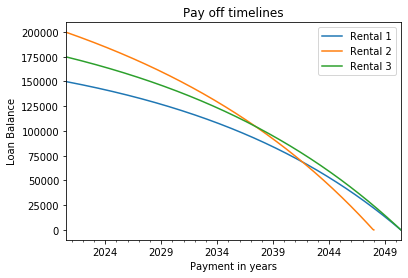

In [18]:
fig, ax = plt.subplots(1,1)
Rental_1.plot(x='Payment_Date', y='Balance', label='Rental 1', ax=ax)
Rental_2.plot(x='Payment_Date', y='Balance', label='Rental 2', ax=ax)
Rental_3.plot(x='Payment_Date', y='Balance', label='Rental 3', ax=ax)
plt.ylabel('Loan Balance')
plt.xlabel('Payment in years')
plt.title('Pay off timelines')

Lets consider the potntial ROI and ROE for these potential properties.

Text(0.5, 1.0, 'ROI')

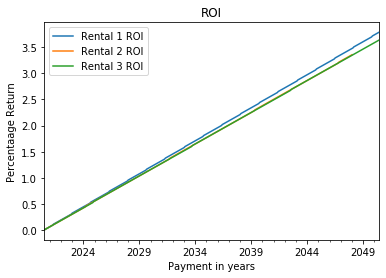

In [19]:
fig, ax = plt.subplots(1,1)
Rental_1.plot(x='Payment_Date', y='ROI', label='Rental 1 ROI', ax=ax)
Rental_2.plot(x='Payment_Date', y='ROI', label='Rental 2 ROI', ax=ax)
Rental_3.plot(x='Payment_Date', y='ROI', label='Rental 3 ROI', ax=ax)
plt.ylabel('Percentaage Return')
plt.xlabel('Payment in years')
plt.title('ROI')

Text(0.5, 1.0, 'ROE')

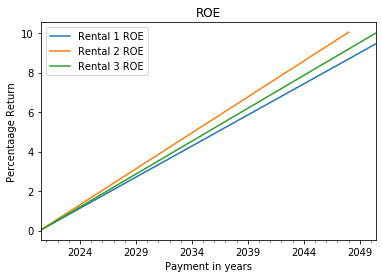

In [20]:
fig, ax = plt.subplots(1,1)
Rental_1.plot(x='Payment_Date', y='ROE', label='Rental 1 ROE', ax=ax)
Rental_2.plot(x='Payment_Date', y='ROE', label='Rental 2 ROE', ax=ax)
Rental_3.plot(x='Payment_Date', y='ROE', label='Rental 3 ROE', ax=ax)
plt.ylabel('Percentaage Return')
plt.xlabel('Payment in years')
plt.title('ROE')

LEts look at one last comparison with the property vaue and cash flow with the loan balance

<Figure size 720x720 with 0 Axes>

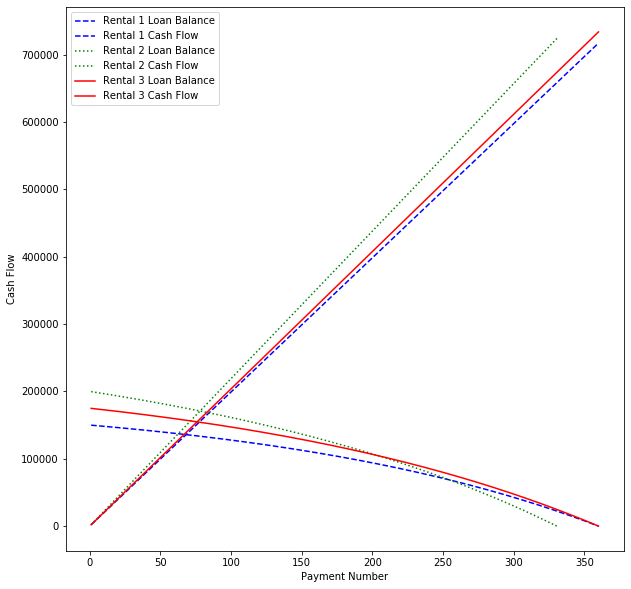

In [21]:
rcParams['figure.figsize'] = 10,10
fig = plt.figure()
fig,ax = plt.subplots()

ax.plot(Rental_1['Balance'], color="blue",ls='--',label='Rental 1 Loan Balance')
ax.plot(Rental_1['Cash Flow'], color="blue", ls='--', label='Rental 1 Cash Flow')

ax.plot(Rental_2['Balance'], color="green", ls=':',label='Rental 2 Loan Balance')
ax.plot(Rental_2['Cash Flow'], color="green", ls=':', label='Rental 2 Cash Flow')

ax.plot(Rental_3['Balance'], color="red", ls='-',label='Rental 3 Loan Balance')
ax.plot(Rental_3['Cash Flow'], color="red", ls='-',label='Rental 3 Cash Flow')

ax.set_xlabel("Payment Number")
ax.set_ylabel("Loan Balance")
ax.set_ylabel("Cash Flow")

plt.legend()
plt.show()

This chart tells us our breakeven points for all three properties.  Looking at this we can identify the property that will pay back the fastest.  Using this knowledge we can chose the property that best fits our portfolio.  